In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from glob import iglob
import os
from random import randint
import tensorflow as tf
from tensorflow import keras as k
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
import tensorflow_addons as tfa
import segmentation_models as sm
sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [2]:
IMAGE_SIZE = 416
BATCH_SIZE = 2
NUM_CLASSES = 11
BUFFER_SIZE = 1000

In [3]:
def plot_pair(img, mask, path=False):
    if path:
        img = cv2.imread(img, cv2.IMREAD_COLOR)
        mask = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)
    plt.figure(figsize=(25, 25))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.subplot(1, 3, 2)
    plt.imshow(mask)

    
def create_mask(pred_mask):
    pred_mask = np.argmax(pred_mask, axis=-1)
    return pred_mask

In [4]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42): # 42 or random.randint()
        super().__init__()
        # both use the same seed, so they'll make the same random changes.
        self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
        self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

        self.augment_inputs = tf.keras.layers.RandomHeight(0.3, seed=seed)
        self.augment_labels = tf.keras.layers.RandomHeight(0.3, seed=seed)

        self.augment_inputs = tf.keras.layers.RandomWidth(0.3, seed=seed)
        self.augment_labels = tf.keras.layers.RandomWidth(0.3, seed=seed)

        self.augment_inputs = tf.keras.layers.RandomRotation(0.3, fill_mode='nearest', seed=seed)
        self.augment_labels = tf.keras.layers.RandomRotation(0.3, fill_mode='nearest', seed=seed)

        self.augment_inputs = tf.keras.layers.RandomZoom(0.3, seed=seed)
        self.augment_labels = tf.keras.layers.RandomZoom(0.3, seed=seed)
        
#         self.augment_inputs = tf.keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE, seed=seed)
#         self.augment_labels = tf.keras.layers.RandomCrop(IMAGE_SIZE, IMAGE_SIZE, seed=seed)

    
    def call(self, inputs, labels):
        inputs = self.augment_inputs(inputs)
        labels = self.augment_labels(labels)
        return inputs, labels

In [5]:
def read_image(img_path, mask):
    image = tf.io.read_file(img_path)
    if mask:
        image = tf.image.decode_png(image, channels=1)
        image.set_shape([None, None, 1])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, dtype=tf.int32)
        image = tf.one_hot(image, NUM_CLASSES)
        image = tf.squeeze(image)
        mask = np.array([True, False, False, False, False, False, True, True, False, False, True])
        image = tf.boolean_mask(image, mask, axis=2)
        image = tf.reshape(image, [IMAGE_SIZE, IMAGE_SIZE, 4])
        image = tf.cast(image, dtype=tf.float32)
    else:
        image = tf.image.decode_png(image, channels=3)
        image.set_shape([None, None, 3])
        image = tf.image.resize(images=image, size=[IMAGE_SIZE, IMAGE_SIZE])
        image = tf.cast(image, dtype=tf.float32)
        image = image/255.
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list, False)
    mask = read_image(mask_list, True)
    return image, mask


def data_generator(image_list, mask_list, train):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    if train == True:
        dataset = dataset.map(Augment())
    return dataset

In [6]:
mask = cv2.imread('train_dataset_train/train/mask/img_0.052994384957747.png', cv2.IMREAD_GRAYSCALE)
img = cv2.imread('train_dataset_train/train/images/img_0.052994384957747.png', cv2.IMREAD_COLOR)
print(f'Image shape: {img.shape}, mask shape: {mask.shape}')
print(f'Image type: {type(img[0, 0, 0])}, mask type: {type(mask[0, 0])}')
print(f'There is {np.array(to_categorical(mask)).shape[-1]} categorys')
print(f'Max mask value: {mask.max()}')
print(True in (mask == 0))
print(True in (mask == 6))
print(True in (mask == 7))
print(True in (mask == 10))

Image shape: (1080, 1920, 3), mask shape: (1080, 1920)
Image type: <class 'numpy.uint8'>, mask type: <class 'numpy.uint8'>
There is 11 categorys
Max mask value: 10
True
True
True
True


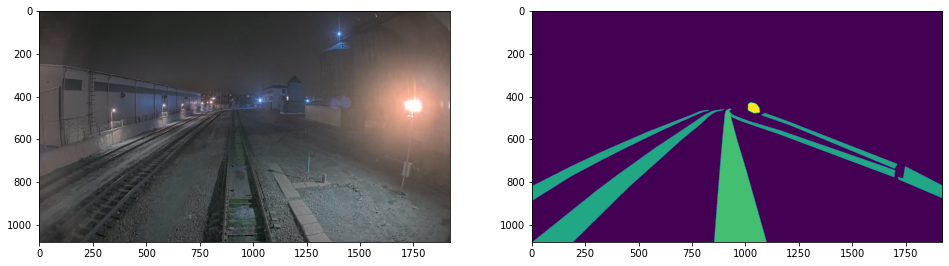

In [7]:
plot_pair(img, mask)

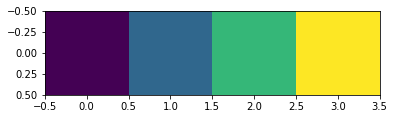

In [8]:
plt.imshow([np.arange(0, 4)])

In [9]:
path = 'C:/Users/vikto/Documents/IT/neural networks/RZD/train_dataset_train/train/'

img_dir = sorted(iglob(os.path.join(path, 'images/*')))
mask_dir = sorted(iglob(os.path.join(path, 'mask/*')))
print(f'Images: {len(img_dir)}, Masks: {len(mask_dir)}')

Images: 8203, Masks: 8203


In [10]:
# for i in range(20):
#     plot_pair(img_dir[i], mask_dir[i], path=True)

In [11]:
length = len(img_dir)
split_length = int(length*0.82)
X_train, X_test = img_dir[:split_length],  img_dir[split_length:]
Y_train, Y_test = mask_dir[:split_length], mask_dir[split_length:]

# X_train, X_test = img_dir[:200],  img_dir[200:240]
# Y_train, Y_test = mask_dir[:200], mask_dir[200:240]

train_indeces = np.random.choice(split_length,
                                 size=split_length,
                                 replace=False)
test_indeces = np.random.choice(length - split_length,
                                size=length - split_length,
                                replace=False)

for count, elem in enumerate(X_train):
    if elem[-4:] != Y_train[count][-4:]:
        print('Fuck')    
        break
for count, elem in enumerate(X_test):
    if elem[-4:] != Y_test[count][-4:]:
        print('Fuck')    
        break
train_length = len(X_train)
test_length = len(X_test)
print(f'Picture names is equal, length of train: {train_length}, test: {test_length}')

Picture names is equal, length of train: 6726, test: 1477


In [12]:
train_dataset = data_generator(X_train, Y_train, train=True)
test_dataset = data_generator(X_test, Y_test, train=False)
# del X_train, Y_train, X_test, Y_test
print(train_dataset, test_dataset, sep='\n'*2)

<MapDataset element_spec=(TensorSpec(shape=(2, 416, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 416, 416, 4), dtype=tf.float32, name=None))>

<BatchDataset element_spec=(TensorSpec(shape=(2, 416, 416, 3), dtype=tf.float32, name=None), TensorSpec(shape=(2, 416, 416, 4), dtype=tf.float32, name=None))>


In [13]:
i = 0
for X, Y in train_dataset:
    i += 1
    if i == 5:
        break

In [14]:
np.array(X).max()

1.0

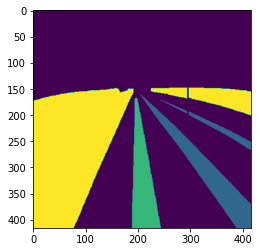

In [15]:
plt.imshow(create_mask(Y[0]))

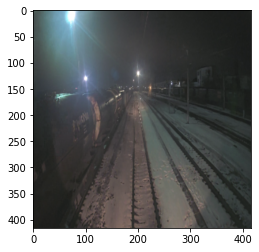

In [16]:
plt.imshow(X[0])

In [17]:
# keras.mixed_precision.set_global_policy('mixed_float16')

In [18]:
BACKBONE = 'mobilenetv2'
preprocess_input = sm.get_preprocessing(BACKBONE)

# train_dataset = preprocess_input(train_dataset)
# test_dataset = preprocess_input(test_dataset)

model = sm.Unet(BACKBONE,
                classes=4,
                activation ='softmax',
                encoder_weights=None,
               input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 416, 416, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1_pad (ZeroPadding2D)      (None, 417, 417, 3)  0           ['input_1[0][0]']                
                                                                                                  
 Conv1 (Conv2D)                 (None, 208, 208, 32  864         ['Conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

 block_2_add (Add)              (None, 104, 104, 24  0           ['block_1_project_BN[0][0]',     
                                )                                 'block_2_project_BN[0][0]']     
                                                                                                  
 block_3_expand (Conv2D)        (None, 104, 104, 14  3456        ['block_2_add[0][0]']            
                                4)                                                                
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, 104, 104, 14  576        ['block_3_expand[0][0]']         
 ization)                       4)                                                                
                                                                                                  
 block_3_expand_relu (ReLU)     (None, 104, 104, 14  0           ['block_3_expand_BN[0][0]']      
          

 block_6_depthwise (DepthwiseCo  (None, 26, 26, 192)  1728       ['block_6_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_6_depthwise_BN (BatchNor  (None, 26, 26, 192)  768        ['block_6_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_6_depthwise_relu (ReLU)  (None, 26, 26, 192)  0           ['block_6_depthwise_BN[0][0]']   
                                                                                                  
 block_6_project (Conv2D)       (None, 26, 26, 64)   12288       ['block_6_depthwise_relu[0][0]'] 
                                                                                                  
 block_6_p

                                                                                                  
 block_10_expand_BN (BatchNorma  (None, 26, 26, 384)  1536       ['block_10_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_10_expand_relu (ReLU)    (None, 26, 26, 384)  0           ['block_10_expand_BN[0][0]']     
                                                                                                  
 block_10_depthwise (DepthwiseC  (None, 26, 26, 384)  3456       ['block_10_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_10_depthwise_BN (BatchNo  (None, 26, 26, 384)  1536       ['block_10_depthwise[0][0]']     
 rmalizati

                                                                                                  
 block_13_project_BN (BatchNorm  (None, 13, 13, 160)  640        ['block_13_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_14_expand (Conv2D)       (None, 13, 13, 960)  153600      ['block_13_project_BN[0][0]']    
                                                                                                  
 block_14_expand_BN (BatchNorma  (None, 13, 13, 960)  3840       ['block_14_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_14_expand_relu (ReLU)    (None, 13, 13, 960)  0           ['block_14_expand_BN[0][0]']     
          

 nate)                          )                                ',                               
                                                                  'block_13_expand_relu[0][0]']   
                                                                                                  
 decoder_stage0a_conv (Conv2D)  (None, 26, 26, 256)  4276224     ['decoder_stage0_concat[0][0]']  
                                                                                                  
 decoder_stage0a_bn (BatchNorma  (None, 26, 26, 256)  1024       ['decoder_stage0a_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 decoder_stage0a_relu (Activati  (None, 26, 26, 256)  0          ['decoder_stage0a_bn[0][0]']     
 on)                                                                                              
          

 decoder_stage3b_conv (Conv2D)  (None, 208, 208, 32  9216        ['decoder_stage3a_relu[0][0]']   
                                )                                                                 
                                                                                                  
 decoder_stage3b_bn (BatchNorma  (None, 208, 208, 32  128        ['decoder_stage3b_conv[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 decoder_stage3b_relu (Activati  (None, 208, 208, 32  0          ['decoder_stage3b_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 decoder_stage4_upsampling (UpS  (None, 416, 416, 32  0          ['decoder_stage3b_relu[0][0]']   
 ampling2D

In [20]:
# tf.keras.utils.plot_model(model)

In [21]:
print(f'batches in dataset: {len(X_train) // BATCH_SIZE}')

batches in dataset: 3363


In [22]:
INIT_LR = 2e-5
MAX_LR = 7e-3
EPOCHS = 14
# DECAY_STEPS = 36e2
# DECAY_RATE = 0.25
steps_per_epoch = len(X_train) // BATCH_SIZE
# steps_per_epoch = 2000
# steps_per_epoch = 50


clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2*steps_per_epoch
)

# lr_schedule = k.optimizers.schedules.ExponentialDecay(
#     initial_learning_rate=INIT_LR,
#     decay_steps=DECAY_STEPS,
#     decay_rate=DECAY_RATE)

Text(0, 0.5, 'Learning Rate')

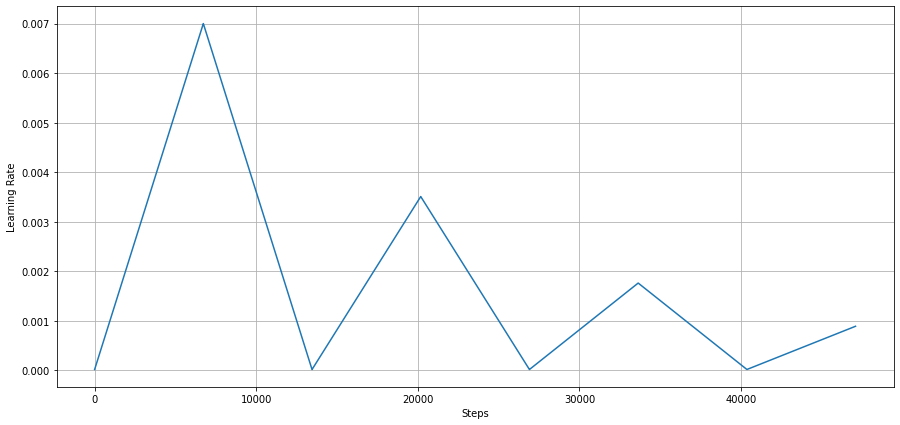

In [23]:
step = np.arange(0, EPOCHS * steps_per_epoch)
lr = clr(step)
# lr = lr_schedule(step)
plt.figure(figsize=(15, 7))
plt.grid(True)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")

In [24]:
print(f'Start l_r: {clr(0)}, finish l_r: {clr(step[-1])}')

Start l_r: 1.9999999494757503e-05, finish l_r: 0.0008923701825551689


In [25]:
checkpoint_filepath = './tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [26]:
model.compile(
    tf.keras.optimizers.Adam(clr),
#     "Nadam",
#     'rmsprop',
    loss=sm.losses.JaccardLoss(),
#     loss='CategoricalCrossentropy',
    metrics=[
#         tf.keras.metrics.MeanIoU(4, name='mean_io_u'),
        sm.metrics.IOUScore(),
        tf.keras.metrics.Accuracy()]
)

In [27]:
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=EPOCHS,
#                     callbacks=[model_checkpoint_callback],
                    steps_per_epoch=steps_per_epoch
                   )

Epoch 1/14
3363/3363 [==============================] - 3146s 928ms/step - loss: 0.5283 - iou_score: 0.4717 - accuracy: 0.0124 - val_loss: 0.7810 - val_iou_score: 0.2190 - val_accuracy: 0.0029
Epoch 2/14
3363/3363 [==============================] - 1573s 468ms/step - loss: 0.4355 - iou_score: 0.5645 - accuracy: 0.1714 - val_loss: 0.6018 - val_iou_score: 0.3982 - val_accuracy: 0.2133
Epoch 3/14
3363/3363 [==============================] - 1568s 466ms/step - loss: 0.3867 - iou_score: 0.6133 - accuracy: 0.2633 - val_loss: 0.7768 - val_iou_score: 0.2232 - val_accuracy: 0.2151
Epoch 4/14
3363/3363 [==============================] - 1664s 495ms/step - loss: 0.3350 - iou_score: 0.6650 - accuracy: 0.3068 - val_loss: 0.3167 - val_iou_score: 0.6833 - val_accuracy: 0.3120
Epoch 5/14
3363/3363 [==============================] - 1810s 538ms/step - loss: 0.3123 - iou_score: 0.6877 - accuracy: 0.3336 - val_loss: 0.3521 - val_iou_score: 0.6479 - val_accuracy: 0.3028
Epoch 6/14
3363/3363 [=============

In [28]:
model.save('model_416_Unet')

INFO:tensorflow:Assets written to: model_416_Unet\assets


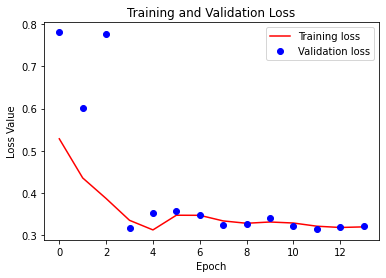

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training loss')
plt.plot(history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend()
plt.show()

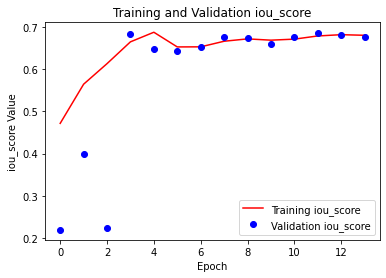

In [30]:
loss = history.history['iou_score']
val_loss = history.history['val_iou_score']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training iou_score')
plt.plot(history.epoch, val_loss, 'bo', label='Validation iou_score')
plt.title('Training and Validation iou_score')
plt.xlabel('Epoch')
plt.ylabel('iou_score Value')
plt.legend()
plt.show()

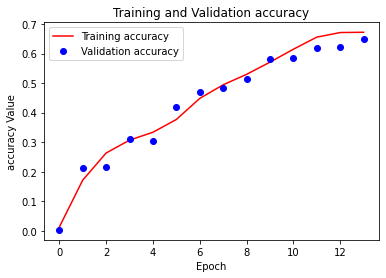

In [31]:
loss = history.history['accuracy']
val_loss = history.history['val_accuracy']

plt.figure()
plt.plot(history.epoch, loss, 'r', label='Training accuracy')
plt.plot(history.epoch, val_loss, 'bo', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy Value')
plt.legend()
plt.show()

In [32]:
upper = k.Sequential([k.layers.UpSampling2D(4, interpolation='bilinear')])

In [33]:
img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE))
img = np.expand_dims(img, axis=0)
print(img.shape)

(1, 416, 416, 3)


In [34]:
prediction = upper(model.predict(img/255.))[0]
print(prediction.shape)

(1664, 1664, 4)


In [35]:
prediction = create_mask(prediction)
print(prediction.shape)

(1664, 1664)


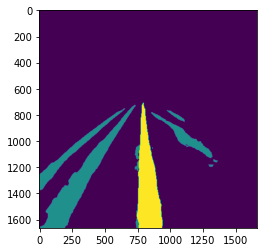

In [36]:
plt.imshow(prediction)

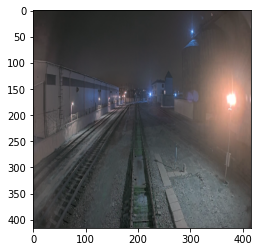

In [37]:
plt.imshow(np.squeeze(img))